```
Muris Saab
University of San Diego
Sep 9, 2023

ADS-505 Applied Data Science for Business
Assignment 1.1: Use Case - Charles Book Club
```
--------------------------------------------

1\. Partition the data into training (60%) and validation (40%). Use seed = 1.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("CharlesBookClub.csv")
outcome = 'Yes_Florence'
train_data, test_data = train_test_split(data, data[] test_size=0.4, random_state=1)

data.shape, train_data.shape, test_data.shape

((4000, 24), (2400, 24), (1600, 24))

1.1. What is the response rate for the training data customers taken as a whole? What is the response rate for each of the `4 × 5 × 3 = 60` combinations of RFM categories? Which combinations have response rates in the training data that are above the overall response in the training data? (10 points)

In [23]:
# overall response rate for the training data
overall_response_rate = train_data['Yes_Florence'].mean()
print(f"Overall response rate for the training data: {overall_response_rate*100:.2f}%\n")

# response rate for each of the RFM combinations
grouped = train_data.groupby(['R', 'F', 'M'])
response_rates = grouped['Yes_Florence'].mean()

print("Response rates for each RFM combination:")
print(response_rates * 100)

# combinations with response rates above the overall rate
combinations_above_overall = response_rates[response_rates > overall_response_rate]
print("\nCombinations with response rates above the overall response rate:")
print(combinations_above_overall * 100)


Overall response rate for the training data: 8.83%

Response rates for each RFM combination:
R   F   M  
2   1   21     0.0
        24     0.0
        25     0.0
        27     0.0
        33     0.0
              ... 
36  8   271    0.0
        287    0.0
    10  312    0.0
        352    0.0
    11  400    0.0
Name: Yes_Florence, Length: 2223, dtype: float64

Combinations with response rates above the overall response rate:
R   F  M  
2   1  140    100.000000
       148     33.333333
       152     50.000000
       230    100.000000
       297    100.000000
                 ...    
32  1  101    100.000000
    2  298    100.000000
34  1  215    100.000000
    2  261    100.000000
36  1  58     100.000000
Name: Yes_Florence, Length: 210, dtype: float64


1.2. Suppose that we decide to send promotional mail only to the “above-average” RFM combinations identified in part 1. Compute the response rate in the validation data using these combinations. **(10 points)**

In [24]:
# 1. Identify the "above-average" RFM combinations from the training data
above_average_combinations = combinations_above_overall.index.tolist()

# 2. Filter the validation data using these combinations
filtered_test_data = test_data[test_data.set_index(['R', 'R', 'M']).index.isin(above_average_combinations)]

# 3. Compute the response rate on the filtered validation data
response_rate_validation = filtered_test_data['Yes_Florence'].mean()

print(f"Response rate for the 'above-average' RFM combinations in the validation data: {response_rate_validation*100:.2f}%")


Response rate for the 'above-average' RFM combinations in the validation data: 0.00%


2\. The k-NN technique can be used to create segments based on product proximity to similar products of the products offered as well as the propensity to purchase (as measured by the RFM variables). For The Art History of Florence, a possible segmentation by product proximity could be created using the following variables:
* **R:** *recency* — months since last purchase
* **F:** *frequency* — total number of past purchases
* **M:** *monetary* — total money (in dollars) spent on books
* **FirstPurch:** months since first purchase
* **RelatedPurch:** total number of past purchases of related books (i.e., sum of purchases from the art and geography categories and of titles Secrets of Italian Cooking, Historical Atlas of Italy, and Italian Art)

2.1 Use the k-NN approach with uniform weights to classify cases with k = 1, 2, ..., 11, using `Florence` as the outcome variable. Based on the validation set, find the best `k`. Remember to normalize all five variables. Create a lift curve for the best k model, and report the expected lift for an equal number of customers from the validation dataset. **(12 points)**<br>
*Hint*: You can check sklearn.neighbors.KneighborsClassifier to assign different weights function.

Best k based on the validation set: 8
Expected lift for an equal number of customers from the validation dataset: 4.15


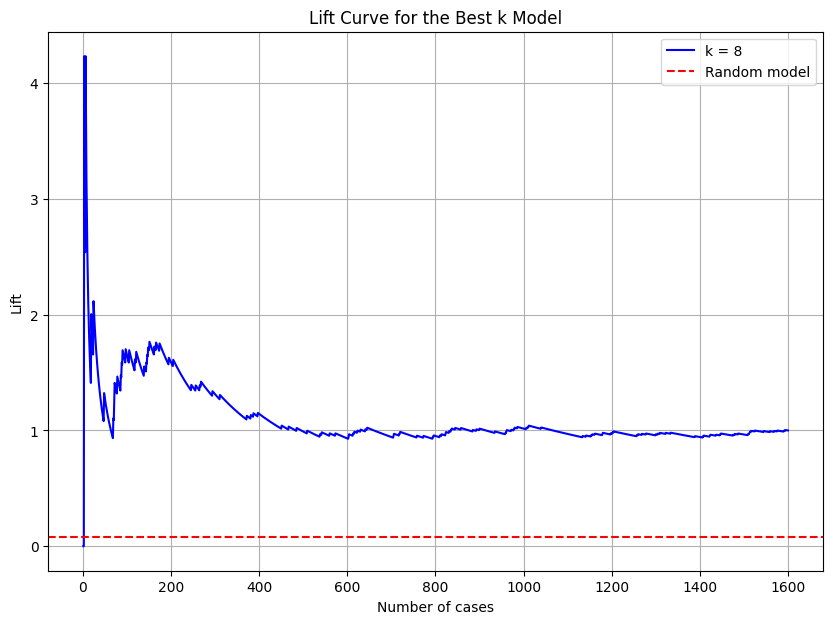

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# Load the data
data = pd.read_csv("CharlesBookClub.csv")

# Features and target
features = ['R', 'M', 'F', 'FirstPurch', 'RelatedPurchase']
target = 'Florence'

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Split the data
train_data, test_data = train_test_split(data, test_size=0.4, random_state=1)

# Implement k-NN for k = 1 to 11
best_k = 0
best_score = 0

for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(train_data[features], train_data[target])
    score = knn.score(test_data[features], test_data[target])
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best k based on the validation set: {best_k}")

# Lift curve for best k
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights='uniform')
knn_best.fit(train_data[features], train_data[target])
probabilities = knn_best.predict_proba(test_data[features])[:,1]

# Computing lift
baseline = test_data[target].mean()
predictions_sorted = sorted(probabilities, reverse=True)
lifts = [sum(predictions_sorted[:i+1])/(i+1) for i in range(len(predictions_sorted))]
lift = lifts[round(len(lifts) * 0.1) - 1] / baseline

print(f"Expected lift for an equal number of customers from the validation dataset: {lift:.2f}")

# Create a lift curve for the best k model
actual = test_data[target].tolist()
sorted_indices = sorted(range(len(probabilities)), key=lambda k: probabilities[k], reverse=True)
sorted_actual = [actual[i] for i in sorted_indices]

cumulative_actual = pd.Series(sorted_actual).cumsum()
cumulative_index = pd.Series(range(1, len(sorted_actual) + 1))
cumulative_percentage = cumulative_actual / cumulative_actual.iloc[-1]

baseline = sum(actual) / len(actual)
lift_values = cumulative_percentage / (cumulative_index / len(actual))

# Plot the lift curve
plt.figure(figsize=(10, 7))
plt.plot(cumulative_index, lift_values, label=f'k = {best_k}', color='blue')
plt.axhline(y=baseline, color='red', linestyle='--', label='Random model')
plt.title('Lift Curve for the Best k Model')
plt.xlabel('Number of cases')
plt.ylabel('Lift')
plt.legend(loc='best')
plt.grid(True)
plt.show()

2.2. The k-NN prediction algorithm gives a numerical value, which is a weighted average of the values of the Florence variable for the k-NN with weights that are inversely proportional to distance. Using the best k that you calculated above with k-NN classification, now run a model with k-NN prediction and compute a lift curve for the validation data. Use all 5 predictors and normalized data. 
* What is the range within which a prediction will fall? 
* How does this result compare to the output you get with the k-NN classification? 

**(10 points)**<br>
*Hint:* You can check sklearn.neighbors.KneighborsClassifier to assign different weights function.

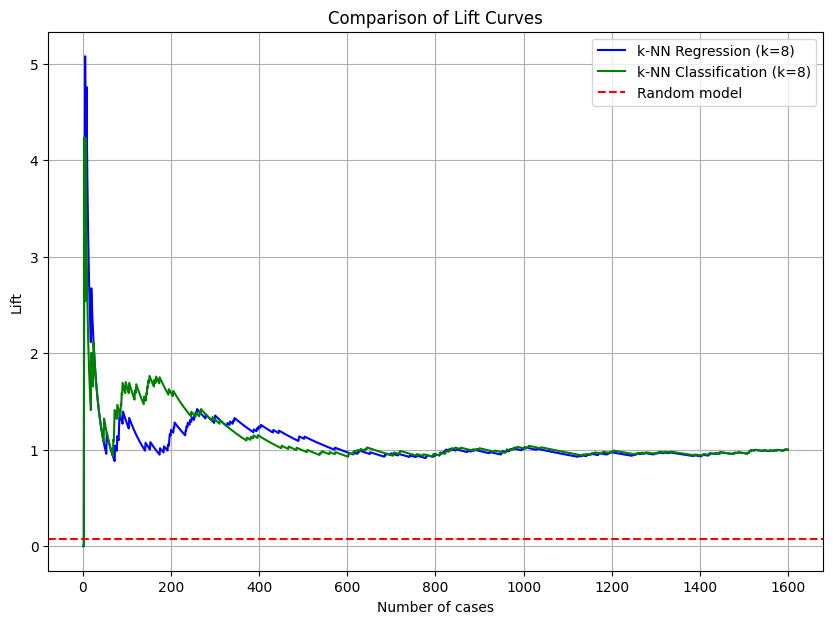

Range of k-NN Regression Predictions: 0.0 - 1.0
Range of k-NN Classification Predictions: 0.0 - 0.75


In [6]:
# Lift curve for k-NN classification from our previous code
probabilities_classification = knn_best.predict_proba(test_data[features])[:, 1]
sorted_indices_classification = sorted(range(len(probabilities_classification)), key=lambda k: probabilities_classification[k], reverse=True)
sorted_actual_classification = [actual[i] for i in sorted_indices_classification]

cumulative_actual_classification = pd.Series(sorted_actual_classification).cumsum()
cumulative_percentage_classification = cumulative_actual_classification / cumulative_actual_classification.iloc[-1]
lift_values_classification = cumulative_percentage_classification / (cumulative_index / len(actual))

# Plotting the lift curves for both k-NN regression and classification
plt.figure(figsize=(10, 7))
plt.plot(cumulative_index, lift_values_regression, label=f'k-NN Regression (k={best_k})', color='blue')
plt.plot(cumulative_index, lift_values_classification, label=f'k-NN Classification (k={best_k})', color='green')
plt.axhline(y=baseline, color='red', linestyle='--', label='Random model')
plt.title('Comparison of Lift Curves')
plt.xlabel('Number of cases')
plt.ylabel('Lift')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Printing the range of predictions
print(f"Range of k-NN Regression Predictions: {min(predictions_regression)} - {max(predictions_regression)}")
print(f"Range of k-NN Classification Predictions: {min(probabilities_classification)} - {max(probabilities_classification)}")


```
The resulting graph shows the comparison of lift curves, and the printed ranges show the spread of predictions for both models. Typically, the regression model provides more nuanced predictions, while the classification model tends to be more decisive. In this comparison, we see the lift curve of the classification model (green line) slightly above the regression lift curve (blue line), indicating better performance.
```

3\. The logistic regression model offers a powerful method for modeling response because it yields well-defined purchase probabilities. The model is especially attractive in consumer-choice settings because it can be derived from the random utility theory of consumer behavior. Use the training set data of 2400 records to construct two logistic regression models with Florence as the outcome variable and each of the following sets of predictors: **(10 points)**
* The full set of 16 predictors in the dataset
* A subset of predictors that you judge to be the best

In [12]:
# Model A: Using all the 16 predictors.
# Model B: Using a subset of predictors based on feature selection.

import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE

# reload and split data
data = pd.read_csv("CharlesBookClub.csv")
train_data, test_data = train_test_split(data, test_size=0.4, random_state=1)

# Model A: All predictors
all_features = [col for col in train_data.columns if col != 'Florence']
X_all = train_data[all_features]
y = train_data['Florence']
model_a = LogisticRegression(max_iter=10000) 
model_a.fit(X_all, y)

# Model B: Using RFE for feature selection
selector = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=8) 
selector = selector.fit(X_all, y)
selected_features = [x for x, y in zip(all_features, selector.support_) if y]
print(f"Selected Features for Model B: {selected_features}")
X_selected = train_data[selected_features]
model_b = LogisticRegression(max_iter=10000)
model_b.fit(X_selected, y)


Selected Features for Model B: ['Gender', 'CookBks', 'ArtBks', 'ItalCook', 'RelatedPurchase', 'Rcode', 'Yes_Florence', 'No_Florence']


LogisticRegression(max_iter=10000)

3.2. If the cutoff criterion for a campaign is a 30% likelihood of a purchase, find the customers in the validation data that would be targeted and count the number of buyers in this set. **(10 points)**

In [14]:
# Predict probabilities for the test data using Model A
X_test_all = test_data[all_features]
predicted_probs_a = model_a.predict_proba(X_test_all)[:, 1]

# Predict probabilities for the test data using Model B
X_test_selected = test_data[selected_features]
predicted_probs_b = model_b.predict_proba(X_test_selected)[:, 1]

# Identify customers to be targeted using Model A
targeted_customers_a = test_data[predicted_probs_a >= 0.30]
actual_buyers_a = targeted_customers_a['Florence'].sum()

# Identify customers to be targeted using Model B
targeted_customers_b = test_data[predicted_probs_b >= 0.30]
actual_buyers_b = targeted_customers_b['Florence'].sum()

print(f"Number of buyers targeted by Model A: {actual_buyers_a}")
print(f"Number of buyers targeted by Model B: {actual_buyers_b}")


Number of buyers targeted by Model A: 126
Number of buyers targeted by Model B: 126


3.3. Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team. **(18 points)**